<a href="https://colab.research.google.com/github/s-thandri/labelflipping/blob/main/german_income/german_credit_MEU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In [2]:
#This function is being used to calculate the statistical parity of the data set
#test_data: The original data frame containing the test data
#predictors: List of the all the column names AKA IV's
#prediction_df: Contains the predicitons made by the DT model
#sensitive_attr: Name of the sensitive attr
#sensitive_attr_cutoff: Cut off value for sensitive attr
#concat_col: Name of column I am creating new dataframe on
def s_parity(test_data, predictors, prediction_df, sensitive_attr, sensitive_attr_cutoff, concat_col):
    #Creating a new DF that contains all the datapoints from the test data and the predictions made from LR model
    #Concat_col: credit_risk_12
    test_demo_df = pd.DataFrame(test_data, columns = predictors)
    predicted_df = pd.DataFrame(prediction_df, columns = [concat_col])
    concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

    #Get the two groups of people totals
    total_unpriv = (len(concat_df[concat_df[sensitive_attr]<sensitive_attr_cutoff]))
    total_priv = (len(concat_df[concat_df[sensitive_attr]>=sensitive_attr_cutoff]))

    #Number of people accepted
    total_credit_unpriv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] < sensitive_attr_cutoff)])
    total_credit_priv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] >= sensitive_attr_cutoff)])

    #Percentage of approved people
    p_unpriv = total_credit_unpriv/total_unpriv
    p_priv = total_credit_priv/total_priv


    #Calculate the parity
    parity = p_priv - p_unpriv


    return parity

In [3]:
#Make changes to make more efficient
#Function used to run the DT model
#train_dataset: Training dataset to train the model
#independent_var: Column names
#dependent_var: Prediction column name
#concat_col: Name of column creating new DF on
def decision_tree(train_dataset, independent_var, dependent_var, concat_col):
        #Split the data up into train and test values and then run the DT model
        #These steps aren't neccessary to consistenly do over and over again
        x = train_dataset[independent_var].values
        y = train_dataset[dependent_var].values
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=310)
        clf = DecisionTreeClassifier(criterion = 'entropy',max_depth = 3, min_samples_leaf=5)
        log = clf.fit(x_train,y_train)
        prediction = log.predict(x_test)

        #Printing the Overall accuracy of the model after one run
        #F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
        #file.write(f'\nAccuracy of the model on Testing Sample Data: {F1_Score}')

        #Prints out the average across all ten run throughs
        #Accuracy_Values=cross_val_score(log, x , y, cv=10, scoring='f1_weighted')

        accuracy = accuracy_score(y_test,prediction)*100

        #After running the model I return a df with the datapoints and the labels
        test_demo_df = pd.DataFrame(x_test, columns = independent_var)
        #Concat_col: credit_risk_12
        predicted_df = pd.DataFrame(prediction, columns = [concat_col])

        return accuracy, test_demo_df, predicted_df

In [4]:
#Defining the columns and creating the Dataframe with all 1000 datapoints
columns = ["checking_account_status", "duration", "credit_history", "purpose", "credit_amount", "savings_account_status", "employment_status", "installment_rate", "personal_status", "other_debtors", "residence_since", "property", "age", "other_installment_plans", "housing", "existing_credits", "job", "num_dependents", "telephone", "foreign_worker", "credit_risk"]
german_df = pd.read_table('german.data', header = None, delim_whitespace=True, names = columns)

In [5]:
#Encode all the non-numeric columns with dummies
encoded_data=pd.get_dummies(german_df,columns=['checking_account_status','credit_history','savings_account_status','employment_status','personal_status','other_debtors','property','other_installment_plans','housing','job','telephone','foreign_worker','purpose'], drop_first=True)

In [6]:
#Initialize all the different columns including predictors and target variable
encoded_data.columns
target_var = 'credit_risk'
predictors = ['duration', 'credit_amount', 'installment_rate',
       'residence_since', 'age', 'existing_credits', 'num_dependents',
       'checking_account_status_A12',
       'checking_account_status_A13', 'checking_account_status_A14',
       'credit_history_A31', 'credit_history_A32', 'credit_history_A33',
       'credit_history_A34', 'savings_account_status_A62',
       'savings_account_status_A63', 'savings_account_status_A64',
       'savings_account_status_A65', 'employment_status_A72',
       'employment_status_A73', 'employment_status_A74',
       'employment_status_A75', 'personal_status_A92', 'personal_status_A93',
       'personal_status_A94', 'other_debtors_A102', 'other_debtors_A103',
       'property_A122', 'property_A123', 'property_A124',
       'other_installment_plans_A142', 'other_installment_plans_A143',
       'housing_A152', 'housing_A153', 'job_A172', 'job_A173', 'job_A174',
       'telephone_A192', 'foreign_worker_A202']


In [7]:
#Setting the columns to each part of the decision tree
#x conatins the IV's
#y contains the DV
x = encoded_data[predictors].values
y = encoded_data[target_var].values

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=310)
#X-train is all the data points for training
#y_train contains the labels for each of the training data points
#x_test contains all the testing data points
#y_test contains the ground truth for each of the test data points

In [9]:
#Run the DT classifier
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_leaf=5)
dt = clf.fit(x_train,y_train)
prediction = dt.predict(x_test)
prediction_prob = dt.predict_proba(x_test)

In [10]:
#Break the test dataframe into different groups
#Unprotected group is everyone <45
#Complement group is everyone >= 45
test_demo_df = pd.DataFrame(x_test, columns = predictors)
predicted_df = pd.DataFrame(prediction, columns = ['credit_risk_12'])
concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

#Get the two groups of people totals
total_unpriv = (len(concat_df[concat_df['age']<45]))
total_priv = (len(concat_df[concat_df['age']>=45]))

#Number of people accepted
total_credit_unpriv = len(concat_df[(concat_df['credit_risk_12'] == 1) & (concat_df['age'] < 45)])
total_credit_priv = len(concat_df[(concat_df['credit_risk_12'] == 1) & (concat_df['age'] >= 45)])

#Percentage of approved people
p_unpriv = total_credit_unpriv/total_unpriv
p_priv = total_credit_priv/total_priv

statistical_parity = p_priv - p_unpriv
print(f'Statistical Parity: {statistical_parity:.5f}')


Statistical Parity: -0.15625


In [11]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(x_train, columns = predictors)
train_outcome_df = pd.DataFrame(y_train, columns = ['credit_risk'])
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [12]:
# Obtain predicted probabilities on the training data
predicted_probabilities = dt.predict_proba(x_train)

In [13]:
#Make a copy of the original training dataframe to make changes on
copy_train_full_df = train_full_df.copy()

In [14]:
#Grab the original label of the DP in the copy dataframe and store in lists along with the index
label = []
row_index = []
for index, row in copy_train_full_df.iterrows():
  label.append(copy_train_full_df.at[index,'credit_risk'])
  row_index.append(index)


In [15]:
#Calculate the first part of the MEU equation
MEU_part1_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,0]
    MEU_part1_calc = prob1 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)
  elif value == 2:
    prob2 = predicted_probabilities[index,1]
    MEU_part1_calc = prob2 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)


In [16]:
#Iterate through the copied dataset
#Flip each label and calculate the parity

#When flipping the label make sure convert the flip before into its original value

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
MEU_part2_list_parity = []
#list_acc holds the accuracy of each iteration after a flip
MEU_part2_list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
MEU_part2_list_flip = []

#Iterating through the training dataset
for index, row in copy_train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the decision_tree function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['credit_risk'] == 1:
      #Flip the label
        copy_train_full_df.at[index, 'credit_risk'] = 2

        #Run the decision tree function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = decision_tree(copy_train_full_df, predictors, target_var, 'credit_risk_12')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        #list_parity: contains the parity value after the flip
        MEU_part2_list_parity.append(parity)

        #Flips the label back to its original value
        copy_train_full_df.at[index,'credit_risk'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['credit_risk'] == 2:
        copy_train_full_df.at[index, 'credit_risk'] = 1

        accuracy,test_datapoints, test_prediction = decision_tree(copy_train_full_df, predictors, target_var, 'credit_risk_12')
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        MEU_part2_list_parity.append(parity)

        copy_train_full_df.at[index,'credit_risk'] = 2

In [17]:
#Second part of the calculation by taking the opposite value
MEU_part2_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,1]
    MEU_part2_calc = prob1 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)
  elif value == 2:
    prob2 = predicted_probabilities[index,0]
    MEU_part2_calc = prob2 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)

In [18]:
#Add the two lists together
expected_utility_values = []
for part1, part2 in zip(MEU_part1_list, MEU_part2_list):
    expected_utility_values.append(part1 + part2)

In [19]:
#Flip the lists so that they are in descending order
#Rank the MEUvalues in Increasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(expected_utility_values, row_index))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0])

#Extract the values
sorted_eu_list, sorted_index_list = zip(*sorted_list)

In [20]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_eu_list = list(sorted_eu_list)

#Get the top 500 points in the list
top_index_points = ranked_indices_list[:500]
top_eu_list = ranked_eu_list[:500]

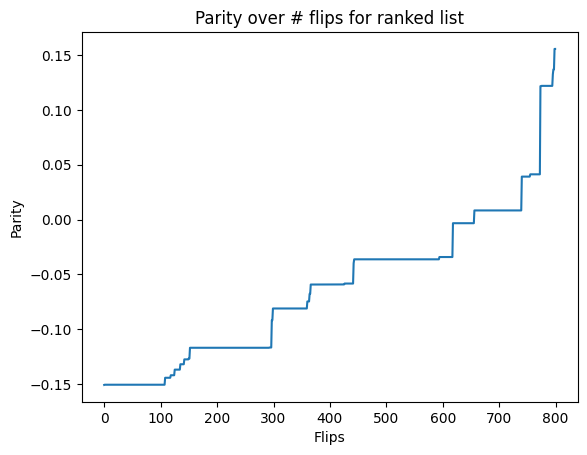

In [21]:
#Plot of the information in the order of the flips of parity
x=range(len(ranked_eu_list))

#Plot the data
plt.plot(x,ranked_eu_list)

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Parity over # flips for ranked list')

#Show the plot
plt.show()